# Miniproject 3: Landing on the Moon

## Introduction

### Description

Traditionally, reinforcement learning has operated on "tabular" state spaces, e.g. "State 1", "State 2", "State 3" etc. However, many important and interesting reinforcement learning problems (like moving robot arms or playing Atari games) are based on either continuous or very high-dimensional state spaces (like robot joint angles or pixels). Deep neural networks constitute one method for learning a value function or policy from continuous and high-dimensional observations. 

In this miniproject, you will teach an agent to play the Lunar Lander game from OpenAI Gym. The agent needs to learn how to land a lunar module safely on the surface of the moon (at coordinate [0,0]). The state space is 8-dimensional and (mostly) continuous, consisting of the X and Y coordinates of the lander, the X and Y velocity, the angle of the lander, the angular velocity, and two booleans indicating whether the left and right leg of the lander have landed on the moon.

The agent gets a reward of +100 for landing safely and -100 for crashing. In addition, it receives "shaping" rewards at every step. It receives positive rewards for moving closer to [0,0], decreasing in velocity, shifting to an upright angle and touching the lander legs on the moon. It receives negative rewards for moving away from the landing site, increasing in velocity, turning sideways, taking the lander legs off the moon and for using fuel (firing the thrusters). The largest reward it can achieve on a step is about +-100. The best score an agent can achieve in an episode is about +250; 

There are two versions of the task: one with discrete controls and one with continuous controls. In the discrete version, the agent can take one of four actions at each time step: [do nothing, fire engines left, fire engines right, fire engines down]. In the continuous version, the agent sets two continuous actions at each time step: the amount of engine thrust and the direction.

We will use Policy Gradient approaches to learn the task. In the previous miniprojects, the network generates a probability distribution over the outputs, and is trained to maximize the probability of a specific target output given an observation. In Policy Gradient methods, the network generates a probability distribution over actions, and is trained to maximize expected future rewards given an observation.

### Prerequisites

- If using docker, download the latest version of the image. Otherwise: You should have a running installation of [tensorflow](https://www.tensorflow.org/install/), [keras](https://keras.io/), [OpenAI Gym](https://gym.openai.com/docs/) and Box2D.
- You should know the concepts of "policy", "policy gradient", "REINFORCE" and "REINFORCE with baseline". If you want to start and haven't seen this yet in class, read Sutton & Barto (2018) Chapter 13 (13.1-13.4 and 13.7).

### What you will learn

- You will learn how to implement a policy gradient neural network using the REINFORCE algorithm.
- You will learn how to implement baselines, including a learned value network.
- You will learn how to adapt your network for both discrete and continuous control.

### Notes 
- Reinforcement learning is noisy! Normally one should average over multiple random seeds with the same parameters to really see the impact of a change to the model, but we won't do this due to time constraints. However, you should be able to see learning over time with every approach. If you don't see any improvement, or very unstable learning, double-check your model and try adjusting the learning rate.

- You may sometimes see "AssertionError: IsLocked() = False" after restarting your code. To fix this, reinitialize the environments by running the Gym Setup code below.

- You will not be marked on the episode movies. If your notebook file is large before uploading, delete them.

### Evaluation criteria

The miniproject is marked out of 15, with a further mark breakdown in each question:
- Exercise 1: 5 points
- Exercise 2: 2 points
- Exercise 3: 3 points
- Exercise 4: 5 points

We may perform random tests of your code but will not rerun the whole notebook.

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Your Names

Before you start, please enter your sciper number(s) in the field below; they are used to load the data. The variable student_2 may remain empty, if you work alone.

In [2]:
sciper = {'student_1': 236838, 
          'student_2': 234445}
seed = sciper['student_1']+sciper['student_2']

## Setup

### Dependencies and constants

In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import logging
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, clear_output
from gym.envs.box2d.lunar_lander import heuristic

import keras
import tensorflow as tf
from tensorflow.contrib.distributions import Beta
from keras.models import Sequential
from keras.layers import Dense, Lambda
from keras.optimizers import Adam
from keras import backend as K

np.random.seed(seed)
tf.set_random_seed(seed*2)

Using TensorFlow backend.


### Gym Setup

Here we load the Reinforcement Learning environments from Gym (both the continuous and discrete versions).

We limit each episode to 500 steps so that we can train faster. 

In [4]:
gym.logger.setLevel(logging.ERROR)
discrete_env = gym.make('LunarLander-v2')
discrete_env._max_episode_steps = 500
discrete_env.seed(seed*3)
continuous_env = gym.make('LunarLanderContinuous-v2')
continuous_env._max_episode_steps = 500
continuous_env.seed(seed*4)
gym.logger.setLevel(logging.WARN)

% matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams["animation.html"] = "jshtml"

### Utilities

We include a function that lets you visualize an "episode" (i.e. a series of observations resulting from the actions that the agent took in the environment).

As well, we will use the "Results" class (a wrapper around a python dictionary) to store, save, load and plot your results. You can save your results to disk with results.save('filename') and reload them with Results(filename='filename'). Use results.pop(experiment_name) to delete an old experiment.

In [5]:
def AddValue(output_size, value):
    return Lambda(lambda x: x + value, output_shape=(output_size,))

def render(episode, env):
    
    fig = plt.figure()
    img = plt.imshow(env.render(mode='rgb_array'))
    plt.axis('off')

    def animate(i):
        img.set_data(episode[i])
        return img,

    anim = FuncAnimation(fig, animate, frames=len(episode), interval=24, blit=True)
    html = HTML(anim.to_jshtml())
    
    plt.close(fig)
    !rm None0000000.png
    
    return html

class Results(dict):
    
    def __init__(self, *args, **kwargs):
        if 'filename' in kwargs:
            data = np.load(kwargs['filename'])
            super().__init__(data)
        else:
            super().__init__(*args, **kwargs)
        self.new_key = None
        self.plot_keys = None
        self.ylim = None
        
    def __setitem__(self, key, value):
        super().__setitem__(key, value)
        self.new_key = key

    def plot(self, window):
        clear_output(wait=True)
        for key in self:
            #Ensure latest results are plotted on top
            if self.plot_keys is not None and key not in self.plot_keys:
                continue
            elif key == self.new_key:
                continue
            self.plot_smooth(key, window)
        if self.new_key is not None:
            self.plot_smooth(self.new_key, window)
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend(loc='lower right')
        if self.ylim is not None:
            plt.ylim(self.ylim)
        plt.show()
        
    def plot_smooth(self, key, window):
        if len(self[key]) == 0:
            plt.plot([], [], label=key)
            return None
        y = np.convolve(self[key], np.ones((window,))/window, mode='valid')
        x = np.linspace(window/2, len(self[key]) - window/2, len(y))
        plt.plot(x, y, label=key)
        
    def save(self, filename='results'):
        np.savez(filename, **self)

### Test runs

To get an idea of how the environment works, we'll plot an episode resulting from random actions at each point in time, and a "perfect" episode using a specially-designed function to land safely within the yellow flags. 

Remove these plots before submitting the miniproject, to reduce the file size.

In [6]:
def run_fixed_episode(env, policy):
    frames = []
    observation = env.reset()
    done = False
    while not done:
        frames.append(env.render(mode='rgb_array'))
        action = policy(env, observation)
        observation, reward, done, info = env.step(action)
    return frames
    
def random_policy(env, observation):
    return env.action_space.sample()

def heuristic_policy(env, observation):
    return heuristic(env.unwrapped, observation)

In [7]:
#episode = run_fixed_episode(discrete_env, random_policy)
#render(episode, discrete_env)

In [8]:
#episode = run_fixed_episode(discrete_env, heuristic_policy)
#render(episode, discrete_env)

## Experiment Loop

This is the method we will call to setup an experiment. Reinforcement learning usually operates on an Observe-Decide-Act cycle, as you can see below.

You don't need to add anything here; you will be working directly on the RL agent.

In [9]:
num_episodes = 3000

def run_experiment(experiment_name, env, num_episodes, learning_rate=0.001, baseline=None):

    #Initiate the learning agent
    agent = RLAgent(n_obs = env.observation_space.shape[0], action_space = env.action_space,
                    learning_rate = learning_rate, discount=0.99, baseline = baseline)

    rewards = []
    all_episode_frames = []
    step = 0
    for episode in range(1, num_episodes+1):
    
        #Update results plot and occasionally store an episode movie
        episode_frames = None
        if episode % 10 == 0:
            results[experiment_name] = np.array(rewards)
            results.plot(10)
        if episode % 500 == 0:
            episode_frames = []
            
        #Reset the environment to a new episode
        observation = env.reset()
        episode_reward = 0

        while True:
        
            if episode_frames is not None:
                episode_frames.append(env.render(mode='rgb_array'))

            # 1. Decide on an action based on the observations
            action = agent.decide(observation)

            # 2. Take action in the environment
            next_observation, reward, done, info = env.step(action)
            episode_reward += reward

            # 3. Store the information returned from the environment for training
            agent.observe(observation, action, reward)

            # 4. When we reach a terminal state ("done"), use the observed episode to train the network
            if done:
                rewards.append(episode_reward)
                if episode_frames is not None:
                    all_episode_frames.append(episode_frames)
                agent.train()
                break

            # Reset for next step
            observation = next_observation
            step += 1
            
    return all_episode_frames, agent

## The Agent

Here we give the outline of a python class that will represent the reinforcement learning agent (along with its decision-making network). We'll modify this class to add additional methods and functionality throughout the course of the miniproject.

NOTE: We have set up this class to implement new functionality as we go along using keyword arguments. If you prefer, you can instead subclass RLAgent for each question.

In [124]:
class RLAgent(object):
    
    def __init__(self, n_obs, action_space, learning_rate, discount, baseline = None):

        #We need the state and action dimensions to build the network
        self.n_obs = n_obs
        #We'll treat the continuous case a bit differently
        self.continuous = 'Discrete' not in str(action_space)
        if self.continuous:
            self.n_act = action_space.shape[0]
            self.act_low = action_space.low
            self.act_range = action_space.high - action_space.low
        else:
            self.n_act = action_space.n
        self.lr = learning_rate
        self.gamma = discount
        
        self.moving_baseline = None
        self.use_baseline = False
        self.use_adaptive_baseline = False
        if baseline == 'adaptive':
            self.use_baseline = True
            self.use_adaptive_baseline = True
        elif baseline == 'simple':
            self.use_baseline = True

        #These lists stores the cumulative observations for this episode
        self.episode_observations, self.episode_actions, self.episode_rewards = [], [], []

        #Build the keras network
        self.network = self._build_network()

    def observe(self, state, action, reward):
        """ This function takes the observations the agent received from the environment and stores them
            in the lists above. If necessary, preprocess the action here for the network. You may also get 
            better results clipping or normalizing the reward to limit its range for training."""   
        
        # Normalize rewards by max recorded value
        """max_reward = max(abs(self.episode_rewards)) #AH : Marche pas si episode_rewards est vide...
        if abs(reward) < max_reward:
            self.episode_rewards.append(reward/max_reward)
        else:
            self.episode_rewards *= max_reward 
            self.episode_rewards.append(reward)
            self.episode_rewards /= reward"""
        
        #AH : Clipping rewards by max rewards said in text above ("The largest reward it can achieve on a step is about +-100")
        max_reward = 100
        if abs(reward) < max_reward:
            self.episode_rewards.append(reward)
        else:
            self.episode_rewards.append(np.sign(reward)*max_reward)
        self.episode_observations.append(np.array(state))
        self.episode_actions.append(action)
        
    def decide(self, state):
        """ This function feeds the observed state to the network, which returns a distribution
            over possible actions. Sample an action from the distribution and return it."""
        #AH : Prediction of the action by the network
        prediction = self.network.predict(np.array([state]))[0]
        #AH : Choose an action from the prediction
        action = np.argmax(prediction)
        return action
    
    #AH :
    def return_max(self, state):
        prediction = self.network.predict(np.array([state]))[0]
        return np.amax(prediction)
    ###
    
    def train(self):
        """ When this function is called, the accumulated observations, actions and discounted rewards from the
            current episode should be fed into the network and used for training. Use the _get_returns function 
            to first turn the episode rewards into discounted returns. """
        # AH : Fit model
        discounted_rewards = self._get_returns()   
        tab = np.zeros((len(self.episode_observations),4))
        T = len(self.episode_observations)
        target = np.zeros((T,4))

        for i in range(T):
            if(i < T-1):
                next_state = self.episode_observations[i+1]
                Qsa = self.return_max(next_state)
                tab[i][self.episode_actions[i]]= self.episode_rewards[i] + self.gamma * Qsa
            else : 
                tab[i][self.episode_actions[i]]= self.episode_rewards[i]
            #tab[i,self.episode_actions[i]]=1
        #self.network.train_on_batch(input,target)
        #self.network.train_on_batch(np.array(self.episode_observations), tab)
        # AH : Version with weights corresponding to ex 1.2
        weights = discounted_rewards #- discounted_rewards.mean() #np.array([self.gamma**i for i in range(T)])
        state = np.array(self.episode_observations)
        target = tab#np.array([self.network.predict(np.array([state]))[0] for state in self.episode_observations])
        #print(len(weights))
        self.network.train_on_batch(state, target, sample_weight = weights)

        self.episode_observations, self.episode_actions, self.episode_rewards = [], [], []

        pass

    def _get_returns(self):
        """ This function should process self.episode_rewards and return the discounted episode returns
            at each step in the episode, then optionally apply a baseline. Hint: work backwards."""
        
        # apply discount (see Lecture 9.1)
        #discounted_rewards = [r*self.gamma**i for (r,i) in zip(self.episode_rewards, range(0,len(self.episode_rewards)))]        
        #AH : discounted_rewards
        T = len(self.episode_rewards)
        discounted_rewards = np.zeros(T)
        
        temp = 0
        for t in reversed(range(0,T)):
                temp = temp * self.gamma + self.episode_rewards[t]
                discounted_rewards[t] = temp
        # no baseline
        if self.use_baseline == False:
            return discounted_rewards
        
        # simple baseline: moving average (see Lecture 10.6)
        else:
            for t in range(T):
                discounted_rewards[t] -= np.mean(discounted_rewards[t:T]) 
            discounted_rewards = discounted_rewards#/(np.std(discounted_rewards)-np.mean(discounted_rewards))
            return discounted_rewards


    def _build_network(self):
        """ This function should build the network that can then be called by decide and train. 
            The network takes observations as inputs and has a policy distribution as output."""  
        hidden_units = 15
        model = Sequential()        
        # input
        model.add(Dense(hidden_units, input_dim=self.n_obs, activation='relu'))
        # hidden layers
        model.add(Dense(hidden_units, activation='relu'))
        model.add(Dense(hidden_units, activation='relu'))
        model.add(Dense(hidden_units, activation='relu'))
        # output
        model.add(Dense(self.n_act, activation='softmax'))
        # build model
        model.compile(optimizer=Adam(lr=self.lr),
                      loss='categorical_crossentropy')
        return model

In [125]:
a = np.array([1,2,3,4])
b = [np.array(a[i]) for i in range(4)]
c = []
c.append(b)
c.append(b)
print(a)
print(a.shape)
len([i for i in range(3)])

[1 2 3 4]
(4,)


3

In [126]:
#AH: Test the modifications of class RLAgent
agent = RLAgent(n_obs = discrete_env.observation_space.shape[0], action_space = discrete_env.action_space,
                learning_rate = 0.001, discount=0.99, baseline = False)
print(agent.network.predict(np.array([discrete_env.reset()])))


[[ 0.39073664  0.17915711  0.24974543  0.18036079]]


## Exercise 1: REINFORCE with simple baseline

### Description

Implement the REINFORCE Policy Gradient algorithm using a deep neural network as a function approximator.

1. Implement the "observe" method of the RLAgent above.
2. Implement the "_build_network" method. Your network should take the 8-dimensional state space as input and output a softmax distribution over the 4 discrete actions. It should have 2-3 hidden layers with about 10-20 units each and ReLU activations. Use the REINFORCE loss function. HINT: Keras has a built-in "categorical cross-entropy" loss, and a "sample_weight" argument in fit/train_on_batch. Consider how these could be used together.
3. Implement the "decide", "train" and "_get_returns" methods using the inputs and outputs of your network. In "_get_returns", implement a baseline based on a moving average of the returns; it should only be in effect when the agent is constructed with the "use_baseline" keyword. In "train", use train_on_batch to form a minibatch from all the experiences in an episode. 
4. Try a few learning rates and pick the best one (the default for Adam is a good place to start). Run the functions below and include the resulting plots, with and without the baseline, for your chosen learning rate. Plot the last movie from the baseline results. 

WARNING: Running any experiments with the same names (first argument in run_experiment) will cause your results to be overwritten. 

**Mark breakdown: 5 points total**
- 3 points for implementing and plotting basic REINFORCE with reasonable performance (i.e. a positive score).
- 2 points for implementing and plotting the simple baseline with reasonable performance.

### Solution

J'ai trouvé un exemple pas mal: https://keon.io/deep-q-learning/

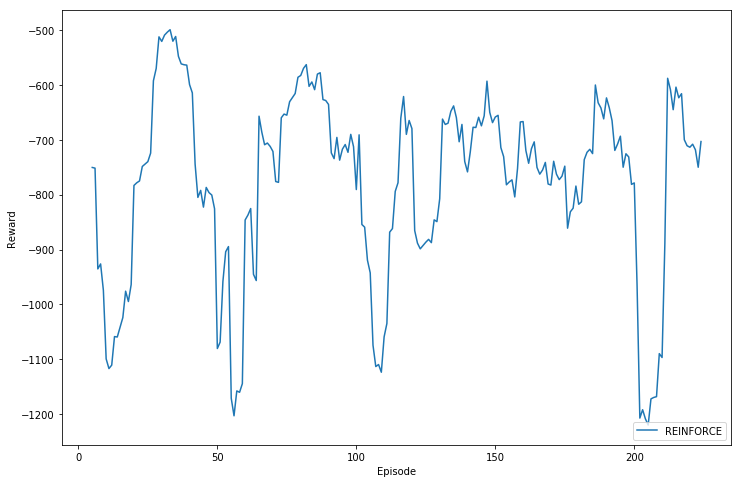

In [ ]:
#Supply a filename here to load results from disk
filename = "SavedData/ex1_results"
results = Results()
learning_rate = 0.001
_, _ = run_experiment("REINFORCE", discrete_env, num_episodes, learning_rate)
episodes, _ = run_experiment("REINFORCE (with baseline)", discrete_env, num_episodes, learning_rate, 
                             baseline='simple')

In [ ]:
render(episodes[-1], discrete_env)

## Exercise 2: Adaptive baseline
### Description

Add a second neural network to your model that learns an observations-dependent adaptive baseline and subtracts it from your discounted returns, to reduce variance in learning.

1. Modify the "_build_network" function of RLAgent to create a second "value network" when "adaptive" is passed for the baseline argument. The value network should have the same or similar structure as the policy network, without the softmax at the output.
2. Subtract the simple baseline from the discounted returns as you did above to get the adjusted returns R - b.
3. In addition to training your policy network, train the value network on the Mean-Squared Error compared to the adjusted returns.
4. Train your policy network on R - b - b(s), i.e. the adjusted returns minus the adaptive baseline (the output of the value network).
5. Try a few learning rates and plot all your best results together (without baseline, with simple baseline, with adaptive baseline). You may or may not be able to improve on the simple baseline! Return the trained model to use it in the next exercise.
6. (Optional, no influence on grade) Try giving the policy and value networks different learning rates to see if you can improve performance. 

TECHNICAL NOTE: Some textbooks may refer to this approach as "Actor-Critic", where the policy network is the "Actor" and the value network is the "Critic". Sutton and Barto (2018) suggest that Actor-Critic only applies when the discounted returns are bootstrapped from the value network output, as you saw in class. This can introduce instability in learning that needs to be addressed with more advanced techniques, so we won't use it for this miniproject. You can read more about state-of-the-art Actor-Critic approaches here: https://arxiv.org/pdf/1602.01783.pdf

**Mark breakdown: 2 points total**
- 2 points for implementing and plotting the adaptive baseline with the other two conditions, with reasonable performance (i.e. at least similar to the performance in Exercise 1).

### Solution

In [ ]:
episodes, d_model = run_experiment("REINFORCE (adaptive baseline)", discrete_env, num_episodes, learning_rate, 
                                   baseline='adaptive')

In [ ]:
render(episodes[-1], discrete_env)

## Exercise 3: Visualizing the Value Function

### Description

Ideally, our value network should have learned to predict the relative values across the input space. We can test this by plotting the value prediction for different observations.

1. Write a function to plot the value network prediction across [x,y] space for given (constant) values of the other state variables. X is always in [-1,1], and Y generally lies in [-0.2,1], where the landing pad is at [0,0].
2. Plot the values for 3-4 combinations of the other 6 state variables, including [0,0,0,0,0,0]. The X and Y velocity are generally within [-1,1], the angle is in [-pi,pi] and the angular velocity lies roughly within [-3,3].  The last two inputs indicating whether the legs have touched the ground are 0 (False) or 1 (True). Use the same color bar limits across the graphs so that they can be compared easily.
3. Answer the questions below in 1-2 sentences each.

**Mark breakdown: 3 points total**
- 2 points for the plots of the value function.
- 1 point for answering the questions below.

### Solution

**Question**: Is there a combination of variables in the ranges above for which you see the highest rewards? Do they make sense?

**Answer**:

**Question**: What about outside of the ranges above? Why might these produce higher values?

**Answer**:

**Question**: Are the values higher before or after the legs touch the surface? Why?

**Answer**:

## Exercise 4: Continuous action space

### Description

One disadvantage of Q-learning-type approaches is that they require that the agent take discrete actions ("left", "right", "up", "down" etc.). In policy gradient, the agent learns a distribution over actions for each observation. That distribution can be either discrete (as we saw above) or continuous.

Here we will switch to continous actions. The agent has a 2D action at each time step: a value in [-1,1] to control the amount of thrust, and a value in [-1,1] to control the left/right direction of the thrust. Since the output is bounded, we will model it with a Beta distribution: http://en.wikipedia.org/wiki/Beta_distribution.

A Beta distribution is defined by 2 parameters: alpha and beta. The network should output both for each action. We will ensure that alpha >= 1 and beta >= 1, which keeps the distribution unimodel and well-behaved. The agent then samples from a distribution defined by [alpha,beta] for each action and transforms the [0,1] output to [-1,1] to act.

Modify your model in the following ways when it detects that self.continuous is True:

1. Your policy network should have 4 outputs: one alpha and one beta for each action. Use a softplus output, which ensures the output is >=0. Then use the AddValue function defined above to add 1 to each unit in the output layer.
2. Create a custom Keras loss function to calculate the log probability of the episode actions taken under the policy. HINT: look at what you can do with the tensorflow.contrib.distributions.Beta module imported above.
3. Adjust the other methods appropriately for the continuous case (use np.random.beta to make a decision).
4. Rerun the agent for the continuous case with several different learning rates and either the simple or adaptive baseline, and plot an episode.
5. Finally, adapt your function from the Exercise 3 to plot the expected thrust and thurst direction across the XY space for your best model. Use several values of the other state variables, including [0,0,0,0,0,0]. Use the expectation of the Beta distribution. There should be 2 plots for each state variable condition: one for thrust and one for thrust direction. 

**Mark breakdown: 5 points total**
- 3 points for plotting the results with continuous actions with several learning rates, with reasonable performance.
- 2 points for plotting the policy in XY space under several conditions.

### Solution

In [ ]:
learning_rates = []
c_models = []
results.plot_keys = []
for lr in learning_rates:
    experiment_name = "Continuous REINFORCE (learning rate: %s)" % str(lr))
    results.plot_keys.append(experiment_name)
    episodes, model = run_experiment(experiment_name, continuous_env, num_episodes, lr, baseline='adaptive')
    c_models.append(model)

In [ ]:
render(episodes[-1], continuous_env)

### Plot

## For your Interest..

The code you've written above can be easily adapted for other environments in Gym. If you like, try playing around with different environments and network structures!